# Lab 1: Evolution of Community Norms

In this lab, we'll cover:
- Changes in online communities over time
- Changes in communities due to sudden events
- Whether community change is driven by longtime users changing their behavior, or new users bringing new behaviors

### Background Information
- `r/TwoXChromosomes` is a feminist subreddit community that started in 2009. People interested in the topic found it by searching or following links that other people posted. (We'll abbreviate it as "TwoX" from now on.)
- On May 7, 2014, it was made a "default subreddit," which means that everyone who went to reddit.com saw a link to TwoXChromosomes on the front page. 
- A flood of new people clicked the link and went to the subreddit. They didn't know the community, and many of them didn't like feminism.
- Users of anti-feminist subreddits, in particular, were angry that a feminist subreddit made the list of defaults. 
- This was a big contraversy, both within reddit and in broader newsmedia.
    - For example: "[Reddit women protest at new front-page position](https://www.theguardian.com/technology/2014/may/13/reddit-women-protest-front-page-subforum-subreddit-position)"
- In February 2017, the moderators of TwoX tried to decrease the hostility in their subreddit by banning all users who post in explicitly anti-feminist subreddits (e.g. r/pussypassdenied) from posting in TwoX.
- We're going to investigate what happened using data from this subreddit.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

## Data
- Here we load the data and do a little cleaning up. 
- Don't worry about how the cleanup is done, just run the code and scroll down.

In [2]:
cols = ['date', 'author', #'controversiality', 
        'TOXICITY', 
        'ATTACK_ON_COMMENTER', 'INFLAMMATORY', 'LIKELY_TO_REJECT', 
        'OBSCENE', 'SEVERE_TOXICITY', 'ATTACK_ON_AUTHOR', 'SPAM', 
        'UNSUBSTANTIAL', 'INCOHERENT', #'ups', 'edited', 
        'id', 
        #'is_submitter', 
        'parent_id', 'replies',# 'score', 
        'subreddit', 'deleted', #'stickied', 'archived', 'collapsed',
        #'body', 
        'politeness', 'sentiment', 'pej_nouns', 
       ]

twox_comments = pd.read_csv('data/merged/TwoXChromosomes_thin.tsv', 
                            sep='\t', usecols=cols)
#convert our dates to the date data type
twox_comments['date'] = pd.to_datetime(twox_comments.date)
twox_comments.shape

(7971947, 20)

In [3]:
twox_comments.columns.values

array(['date', 'author', 'politeness', 'sentiment', 'TOXICITY',
       'ATTACK_ON_COMMENTER', 'INFLAMMATORY', 'LIKELY_TO_REJECT',
       'OBSCENE', 'SEVERE_TOXICITY', 'ATTACK_ON_AUTHOR', 'SPAM',
       'UNSUBSTANTIAL', 'INCOHERENT', 'pej_nouns', 'id', 'parent_id',
       'replies', 'subreddit', 'deleted'], dtype=object)

In [4]:
twox_comments.head()

,date,author,politeness,sentiment,TOXICITY,ATTACK_ON_COMMENTER,INFLAMMATORY,LIKELY_TO_REJECT,OBSCENE,SEVERE_TOXICITY,ATTACK_ON_AUTHOR,SPAM,UNSUBSTANTIAL,INCOHERENT,pej_nouns,id,parent_id,replies,subreddit,deleted
0,2014-06-14 14:11:45,Gangstasaurus_Rex,0.478774,0.1366,0.280680,0.195502,0.306589,0.416138,0.371917,0.160315,0.057300,0.595276,0.476264,0.675580,0,ci7da5r,t1_ci76nel,NaN,TwoXChromosomes,0
1,2014-06-14 14:15:26,[deleted],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,ci7dc99,t3_2834fa,NaN,TwoXChromosomes,1
2,2014-06-14 14:25:25,[deleted],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,ci7di74,t3_284ecf,NaN,TwoXChromosomes,1
3,2014-06-14 15:05:57,rainbowtutucoutu,0.439007,0.0393,0.845157,0.379671,0.386658,0.998965,0.989232,0.466046,0.149044,0.025706,0.271656,0.066258,0,ci7e8bi,t3_283eny,NaN,TwoXChromosomes,0
4,2014-06-14 15:16:43,Eins_Nico,0.402811,0.1179,0.613471,0.354230,0.650630,0.950045,0.988132,0.361007,0.394025,0.004525,0.052447,0.054818,0,ci7efpu,t1_ci79x0v,NaN,TwoXChromosomes,0


### Helper function for plotting
Don't worry about what's in it, just run the code and scroll down.

In [5]:
def make_plot(grouped, columns='id', title=None, top=None, bottom=None, 
             events=None, agg='mean', years=None):
    
    fig, axs = plt.subplots(figsize=(14,10))
    if bottom is not None:
        axs.set_ylim(bottom=bottom)
    if top is not None:
        axs.set_ylim(top=top)
    
    if years is not None:
        axs.set_xlim(left=datetime(year=years[0], month=1, day=1), 
                     right=datetime(year=years[1], month=1, day=1))
                
    if events is not None:
        for e in events.iterrows():
            if e[1].event == 1:
                axs.axvline(e[1].date, color='k', alpha=.75)
                
    if isinstance(columns, str):
        columns = [columns]
        
    if agg == 'mean':
        for c in columns:
            means = grouped[c].mean()
            sems = grouped[c].sem()
            axs.plot(means.index, means)
            axs.fill_between(sems.index, means-(1.96*sems), 
                             means+(1.96*sems), alpha=0.5)
        if title is None:
            title = 'Average scores with 95% confidence interval'
    elif agg == 'count':
        for c in columns:
            counts = grouped.count()[c]
            axs.plot(counts)
        if title is None:
            title = 'Number of comments per month'
    elif agg == 'unique':
        for c in columns:
            counts = grouped[c].nunique()
            axs.plot(counts)
        if title is None:
            title = 'Number of unique ___ per month'
    axs.set_title(title)
    axs.legend()
                
    plt.show()
    return

events = [{'date': datetime(year=2014, month=5, day=7),
          'event': 1,
          'description': 'TwoX made default'},
          {'date': datetime(year=2017, month=2, day=1),
          'event': 1,
          'description': 'TwoX bans anti-feminists'}]
events = pd.DataFrame(events)

### Measuring activity over time
- When TwoX was added to Reddit's front page, people say there was a surge of new users. 
- This code puts the comments into groups: one group for every month. Then it gets the count of comments and the count of people commenting in each month. Finally, it plots them for us to see how the level of activity changes over time. 

In [6]:
#Group the comments by month
monthly = twox_comments.resample('M', on='date')

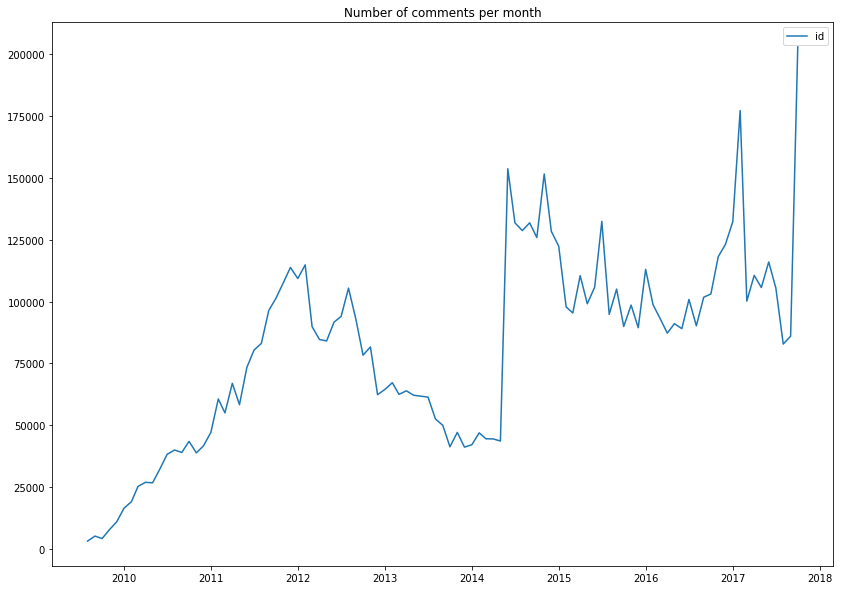

In [7]:
make_plot(monthly, agg='count')

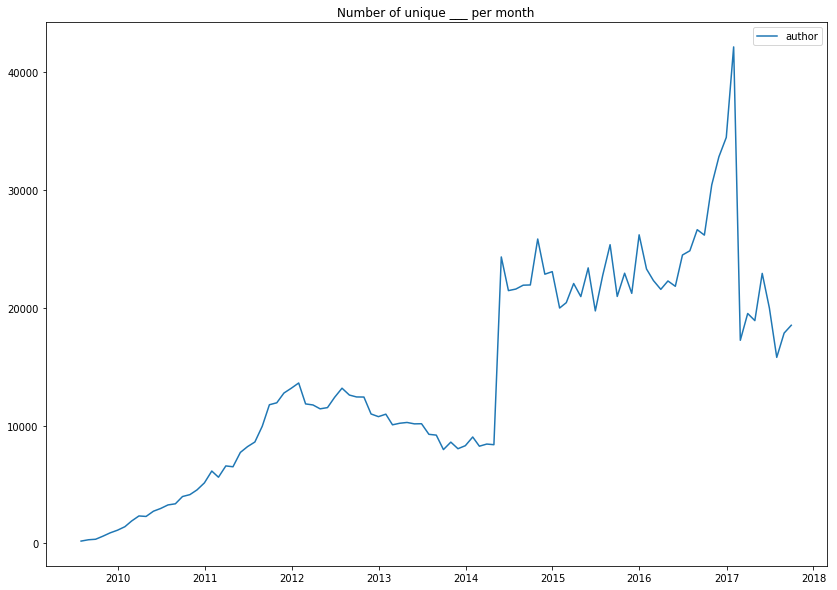

In [8]:
make_plot(monthly, columns='author', agg='unique')

### Notice anything?
- There's a huge jump up in the number of comments and users in May 2014, when it was added to the front page. 
- There's a huge drop down in the number of comments and users in February 2017, when many users were banned.

### Measuring overall conflict
- If there is conflict among people in the subreddit, we might expect more posts to get deleted. 
- The first graph shows us the raw number of posts that are deleted. It looks a lot like the total number of posts, though. 
- The second graph shows us what percent of posts are deleted.

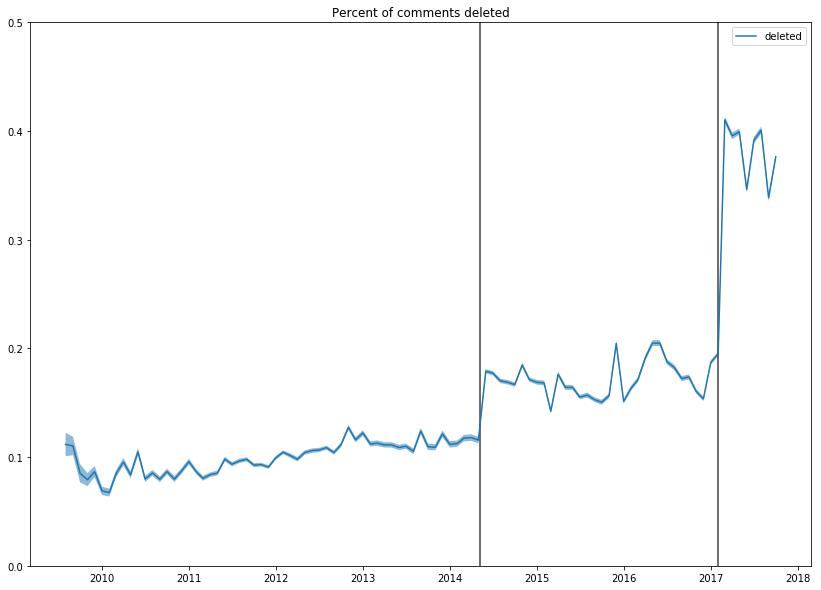

In [9]:
make_plot(monthly, columns='deleted', 
          title="Percent of comments deleted",
          events=events, bottom=0, top=.5)

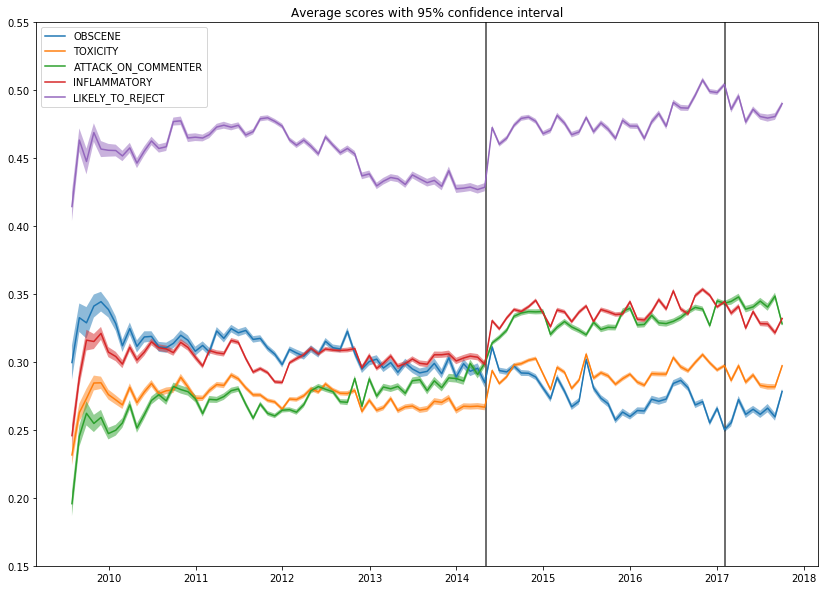

In [10]:
make_plot(monthly, columns=['OBSCENE', 'TOXICITY', 
                            'ATTACK_ON_COMMENTER', 
                            'INFLAMMATORY', 'LIKELY_TO_REJECT'], 
          events=events, top=.55, bottom=.15)

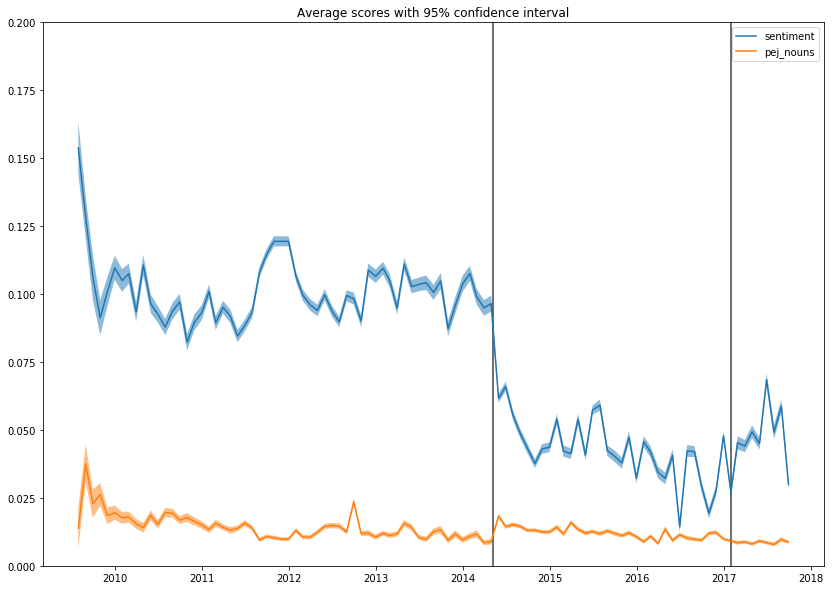

In [11]:
make_plot(monthly, columns=['sentiment', 'pej_nouns'], events=events, top=.2)

## Does it matter when someone joined TwoX?
- We saw above that the community changed dramatically when a large number of new users joined. Now we're going to compare the new and old users.
- Before running the code below, answer these questions:
    - Do you think the overall change is due to new users being different, old users changing their habits, or both? 
    - What ways might the new users be different in our measures of comment civility than the old users?

The code below labels users based on when they joined TwoX.
- Don't worry about how the code in this cell works, just run it and scroll down.

In [23]:
users = {}
groups = [{'name': 'oldtimers', 'direction': 'lt',
           'date': datetime(year=2014, month=4, day=7)},
          {'name': 'before',  'direction': 'lt',
           'date': datetime(year=2014, month=5, day=7)},
          {'name': 'after', 'direction': 'gt',
           'date': datetime(year=2014, month=5, day=7)},
          {'name': '>1m_after',  'direction': 'gt',
           'date': datetime(year=2014, month=6, day=7)},
          {'name': '>1y_after',  'direction': 'gt',
           'date': datetime(year=2015, month=5, day=7)},
          {'name': 'after_ban',  'direction': 'gt',
           'date': datetime(year=2017, month=2, day=7)}]

#select people who only posted one comment ever
tmp = twox_comments.groupby(by='author').count()
users['once'] = set(tmp[tmp.id == 1].index.values)
del tmp

#select all other people, 
firsts = twox_comments[~twox_comments.author.isin(users['once']
                                                 )][['author',
                                                     'date']]
#figure out their first post date
firsts.sort_values(by='date', inplace=True)
firsts.drop_duplicates(subset='author', keep='first', inplace=True)

#select the users in each group
for g in groups:
    if g['direction'] == 'lt':
        users[g['name']] = set(firsts[firsts.date < g['date']].author)
    elif g['direction'] == 'gt':
        users[g['name']] = set(firsts[firsts.date > g['date']].author)

del firsts

def get_cohort(user):
    c = np.nan
    # these need to be in chronological order
    cohorts = ['once', 'before', 'after']#, 'after_ban']
    for co in cohorts:
        if user == '[deleted]':
            c = np.nan
        elif user in users[co]:
            c = co
    
    return c

#label the comments by their author's cohort
twox_comments['cohort'] = twox_comments.author.apply(get_cohort)

#group comments by both date and cohort
cohorts = twox_comments.groupby(by='cohort').resample('M', on='date')

#### A helper function for making plots broken down by user group
- Again, run the code but don't worry about how it works

In [24]:
def plot_users(grouped, column='id', title=None, top=None, bottom=None, 
             events=None, agg='mean', years=None, cohorts='once'):
    
    fig, axs = plt.subplots(figsize=(14,10))
    if bottom is not None:
        axs.set_ylim(bottom=bottom)
    if top is not None:
        axs.set_ylim(top=top)
    
    if years is not None:
        axs.set_xlim(left=datetime(year=years[0], month=1, day=1), 
                     right=datetime(year=years[1], month=1, day=1))
                
    if events is not None:
        for e in events.iterrows():
            if e[1].event == 1:
                axs.axvline(e[1].date, color='k', alpha=.75)
                
    if isinstance(cohorts, str):
        cohorts = [cohorts]
        
    if agg == 'mean':
        means = grouped.mean()
        sems = grouped.sem()
        for c in cohorts:
            axs.plot(means[column][c].index, 
                     means[column][c],
                     label=c)
            axs.fill_between(sems[column][c].index, 
                             means[column][c]-(1.96*sems[column][c]), 
                             means[column][c]+(1.96*sems[column][c]), 
                             alpha=0.5)
        if title is None:
            title = 'Average '+column+' with 95% confidence interval'
    elif agg == 'count':
        counts = grouped.count()
        for c in cohorts:
            axs.plot(counts[column][c], 
                     label=c)
        if title is None:
            title = 'Number of comments per month'
    elif agg == 'unique':
        counts = grouped.nunique()
        for c in cohorts:
            axs.plot(counts[column][c], 
                     label=c)
        if title is None:
            title = 'Number of unique ___ per month'
    axs.set_title(title)
    axs.legend()
                
    plt.show()
    return

### What fraction of posts were made by each group?

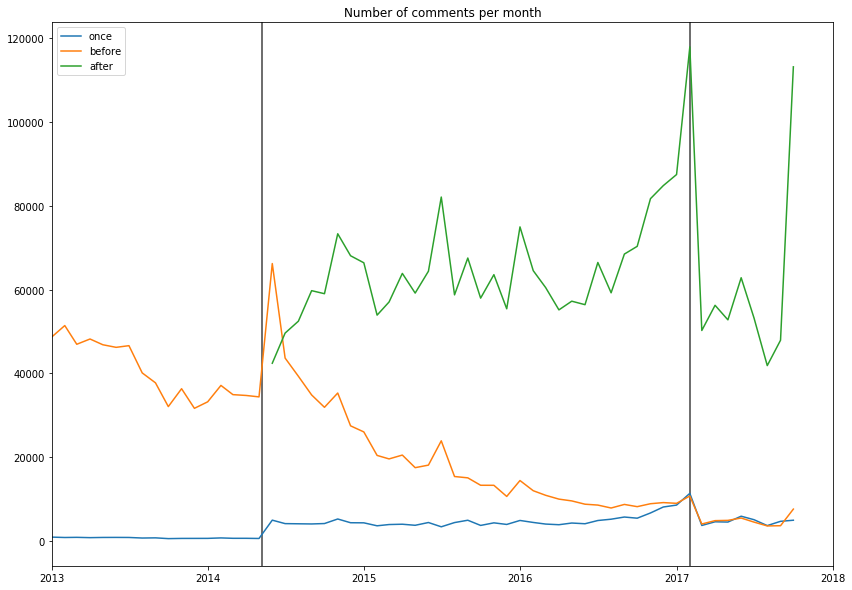

In [25]:
plot_users(cohorts, column='id', 
           cohorts=['once', 'before', 'after'], 
           agg='count', years =[2013,2018], 
           events=events)

### What does each group's posting behavior look like?

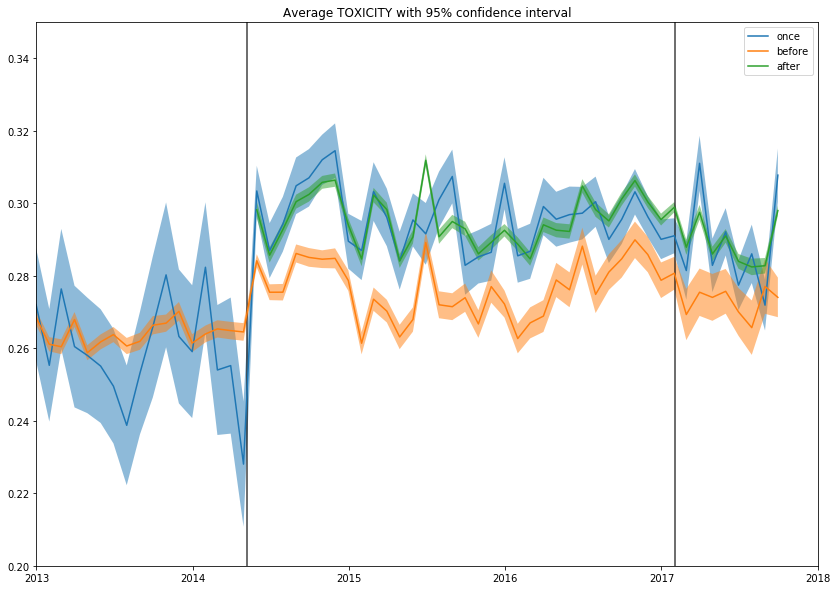

In [26]:
plot_users(cohorts, column='TOXICITY', 
           cohorts=['once', 'before', 'after'], 
           agg='mean', years =[2013,2018], 
           events=events, bottom=.2, top=.35)

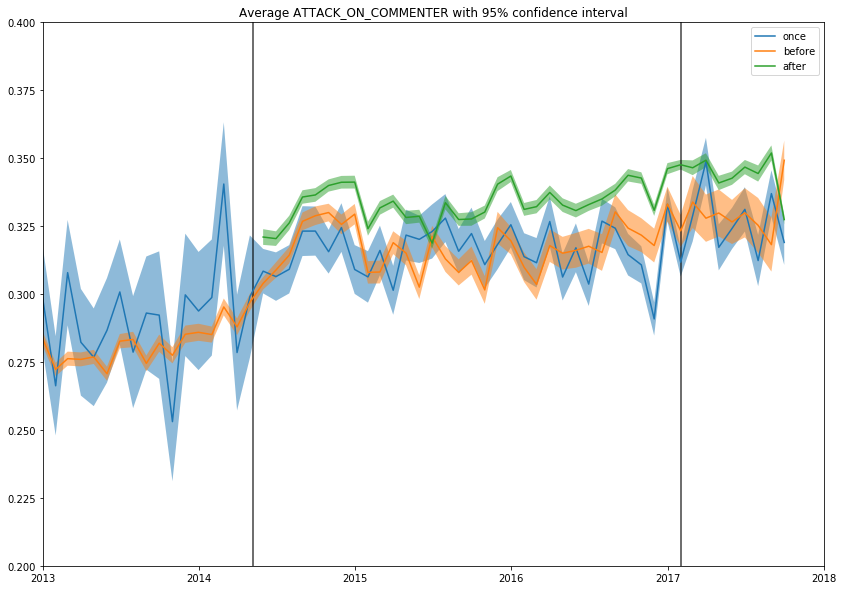

In [27]:
plot_users(cohorts, column='ATTACK_ON_COMMENTER', 
           cohorts=['once', 'before', 'after'], 
           agg='mean', years =[2013,2018], 
           events=events, bottom=.2, top=.4)

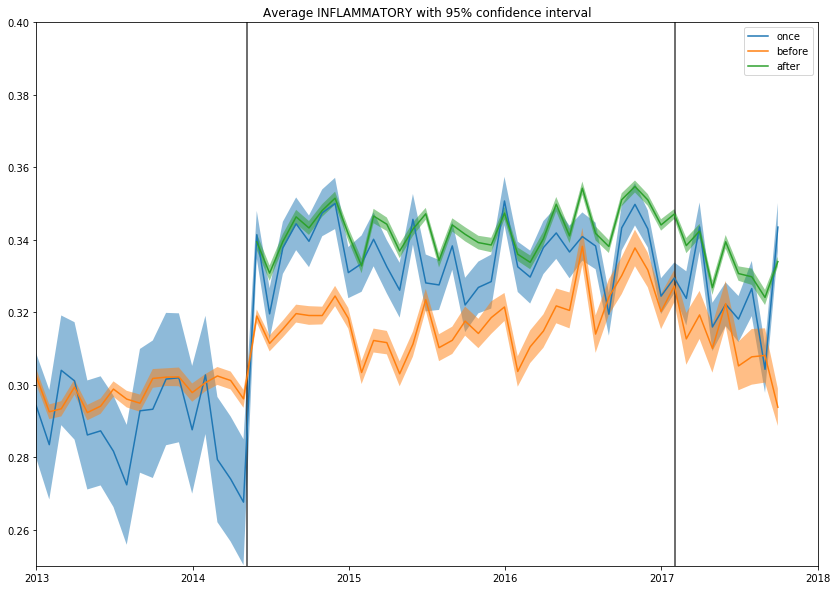

In [28]:
plot_users(cohorts, column='INFLAMMATORY', 
           cohorts=['once', 'before', 'after'], 
           agg='mean', years =[2013,2018], 
           events=events, bottom=.25, top=.4)

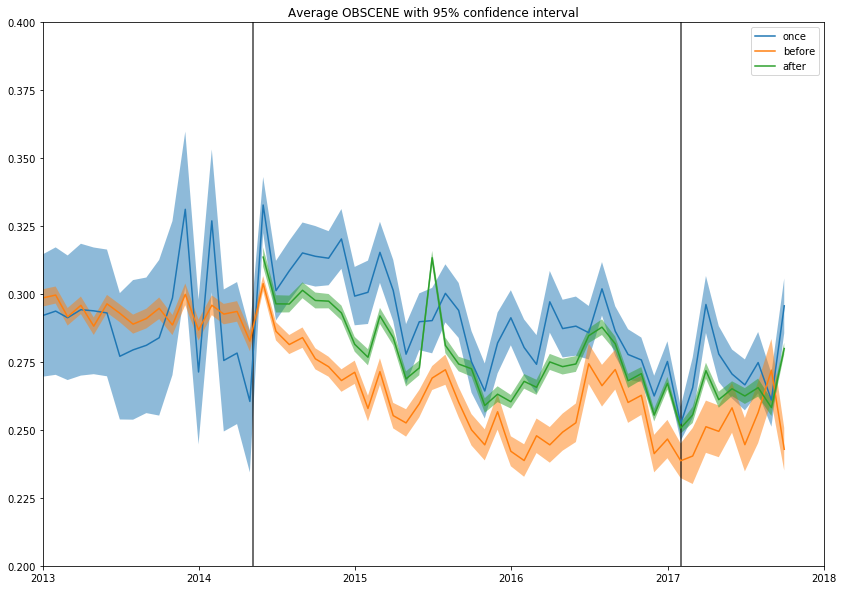

In [29]:
plot_users(cohorts, column='OBSCENE', 
           cohorts=['once', 'before', 'after'], 
           agg='mean', years =[2013,2018], 
           events=events, bottom=.2, top=.4
          )

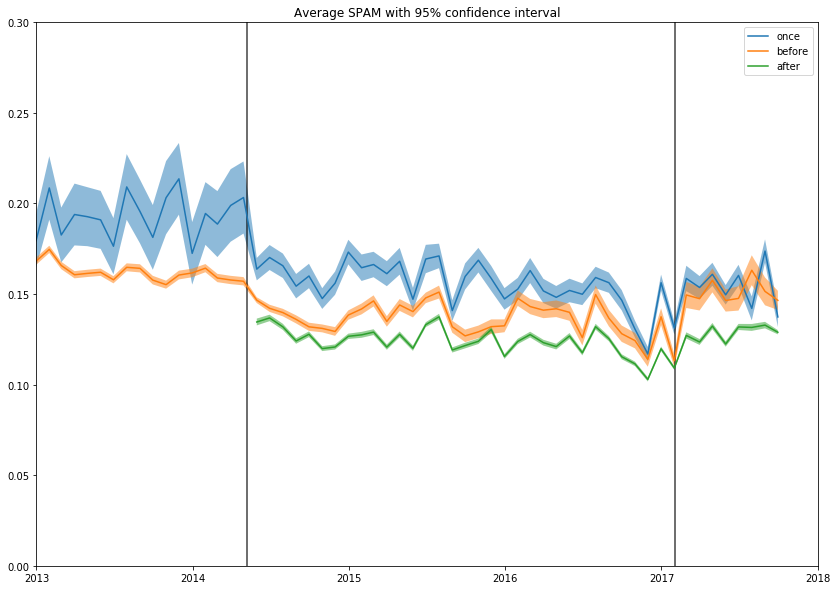

In [30]:
plot_users(cohorts, column='SPAM', 
           cohorts=['once', 'before', 'after'], 
           agg='mean', years =[2013,2018], 
           events=events, bottom=0, top=.3
          )

## Does it matter what other communities a user belongs to?
- Many of the new users in the feminist community TwoX came from anti-feminist communities (e.g. MRAs). 
- Here we compare people who post in both TwoX and MRA subreddits, to see if their behavior is different than TwoX users who don't post in MRA communities. 
- This first cell loads data about what other communities people post in.

In [31]:
MRA_accounts = pd.read_csv('data/mra_authors.tsv', sep='\t')
mra_authors = set(MRA_accounts.author.values)

def get_mra(user):
    c = 'non-MRA'
    if user == '[deleted]':
        c = np.nan
    elif user in mra_authors:
        c = 'MRA'
    return c

twox_comments['MRA'] = twox_comments.author.apply(get_mra)
mra_grouped = twox_comments.groupby(by='MRA').resample('M', on='date')

### How many posts come from each group?

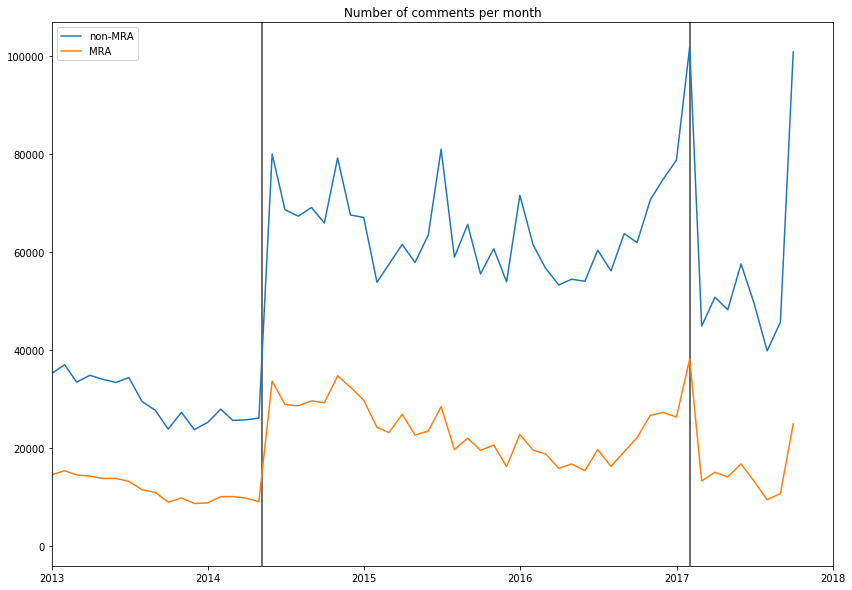

In [21]:
plot_users(mra_grouped, column='id', 
           cohorts=['non-MRA', 'MRA'], 
           agg='count', years =[2013,2018], 
           events=events)

### How does the behavior of each group compare?

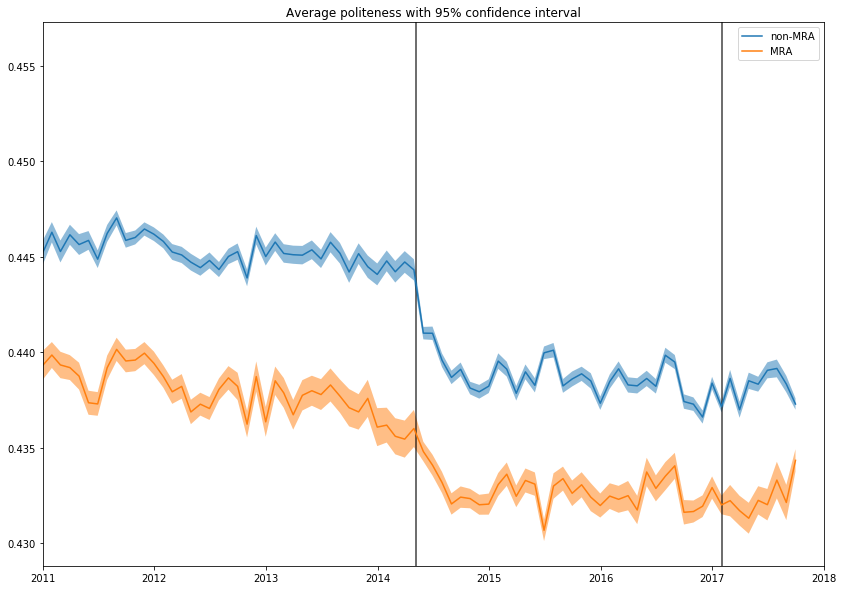

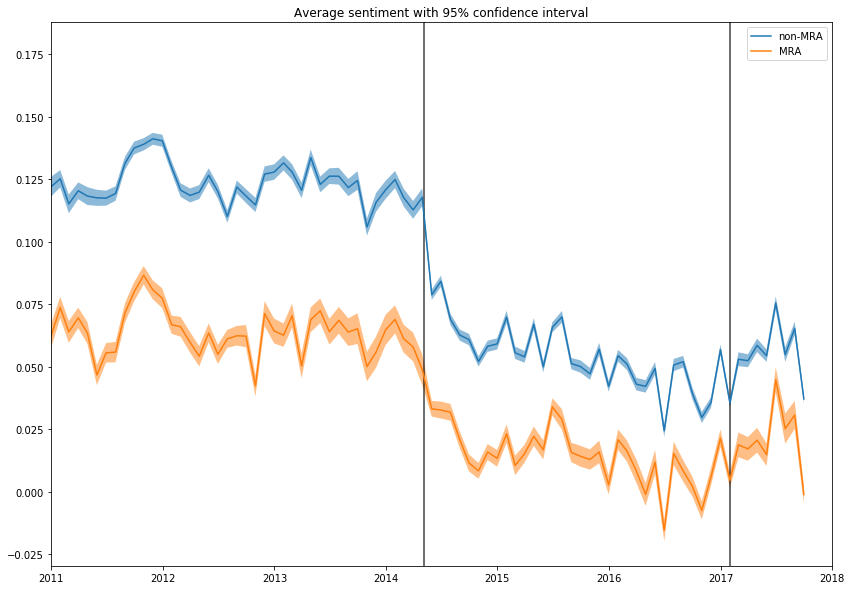

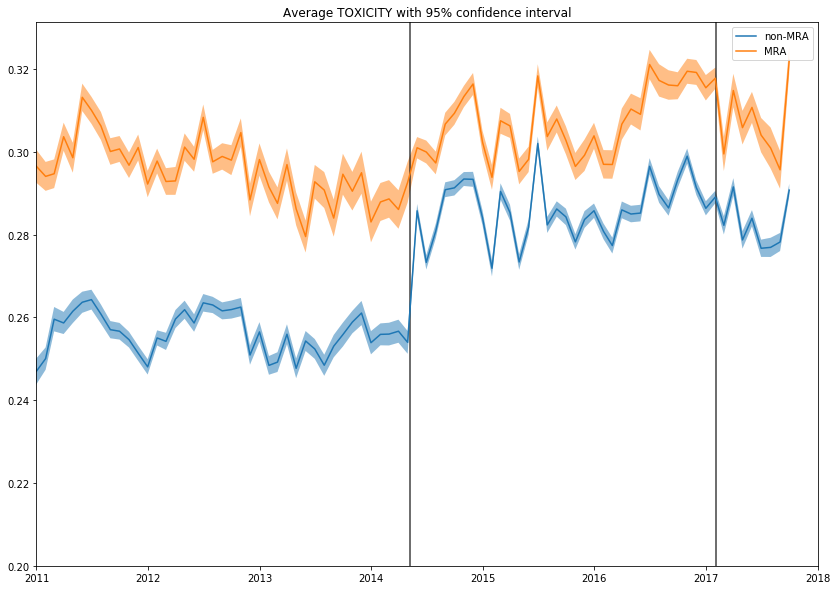

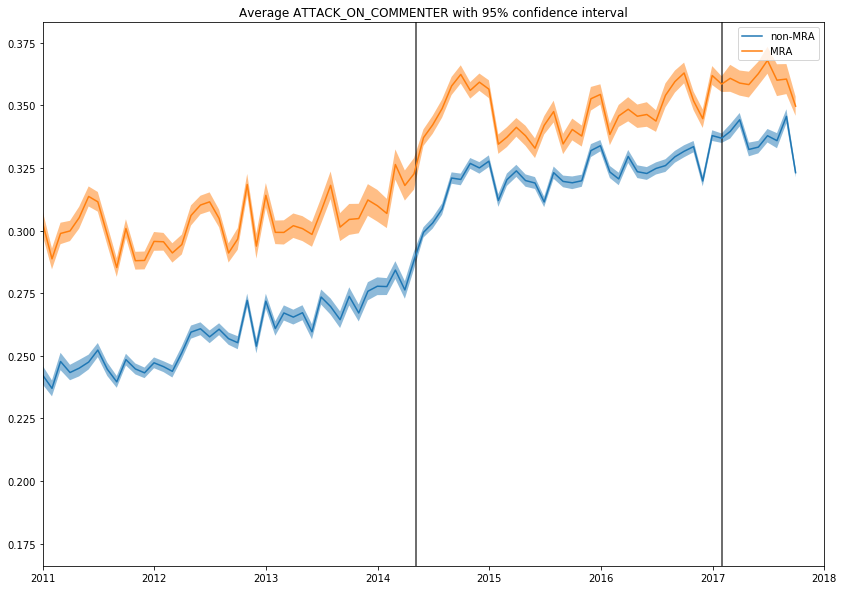

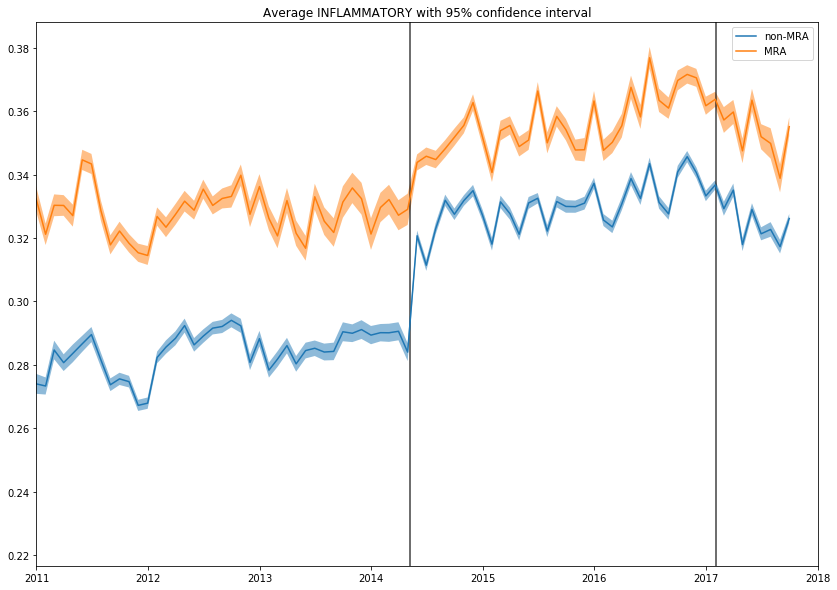

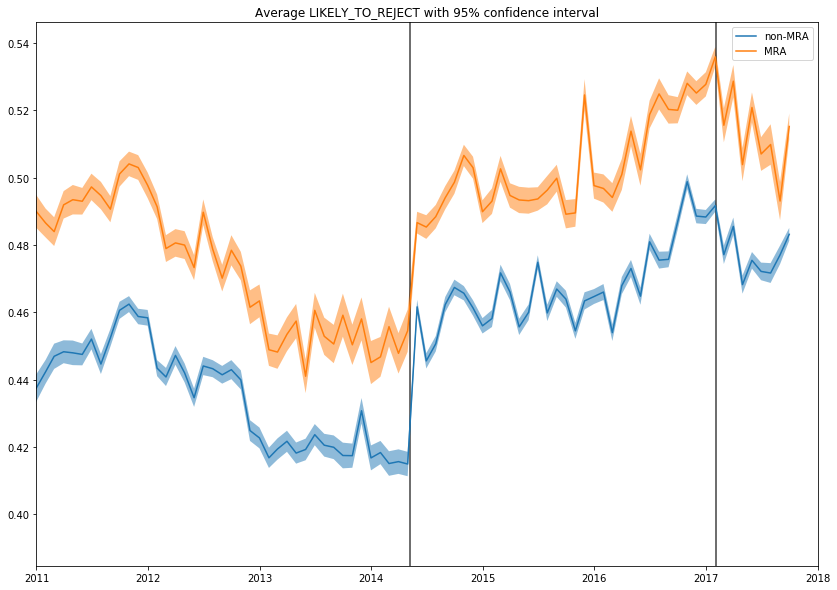

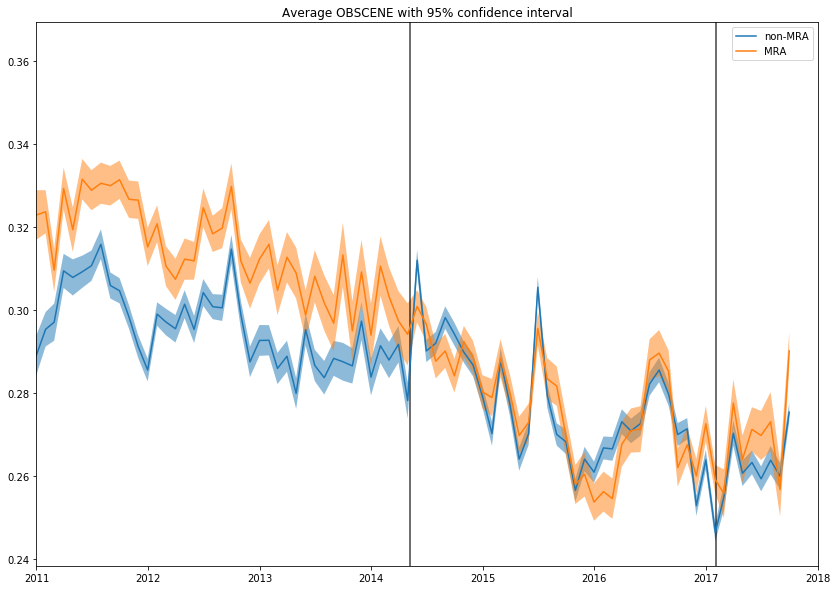

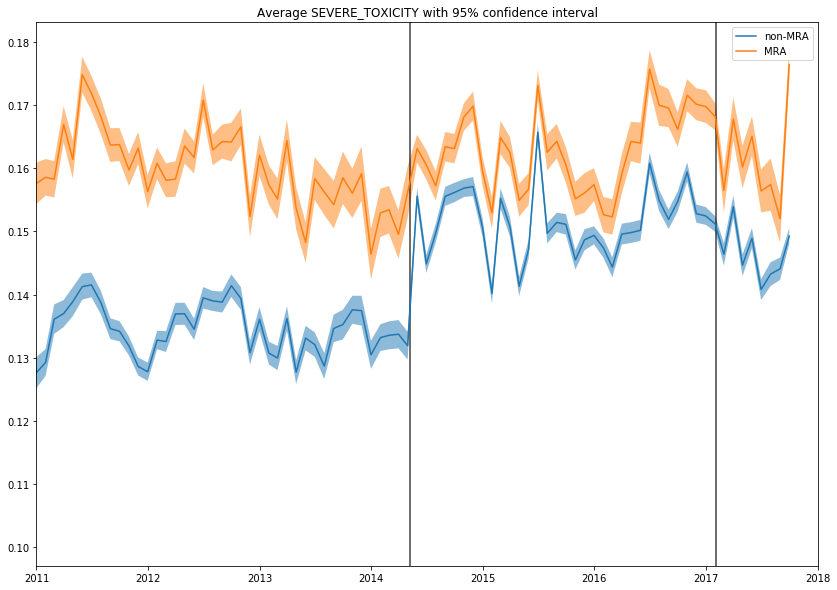

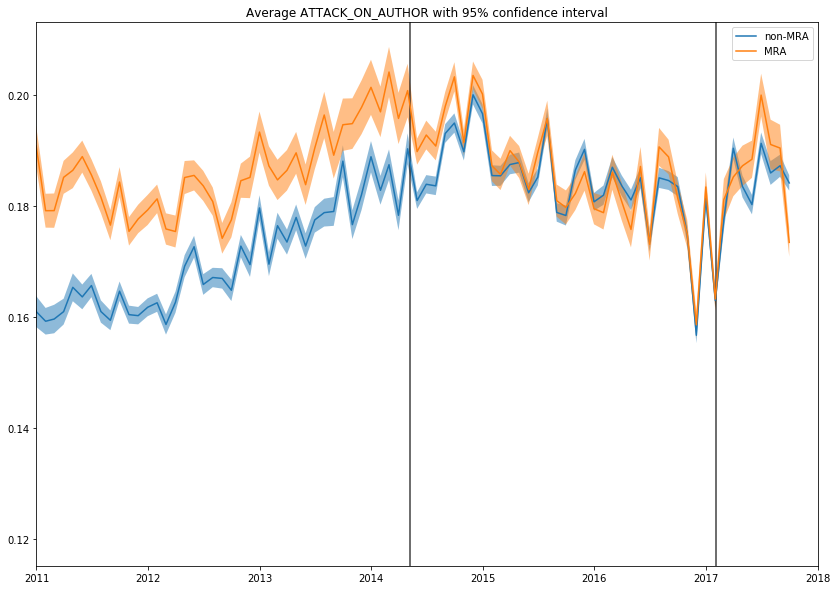

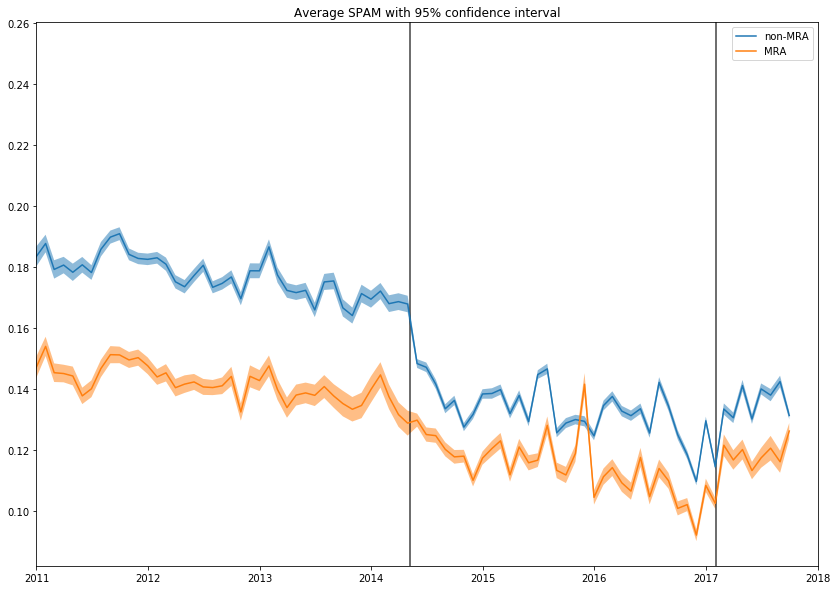

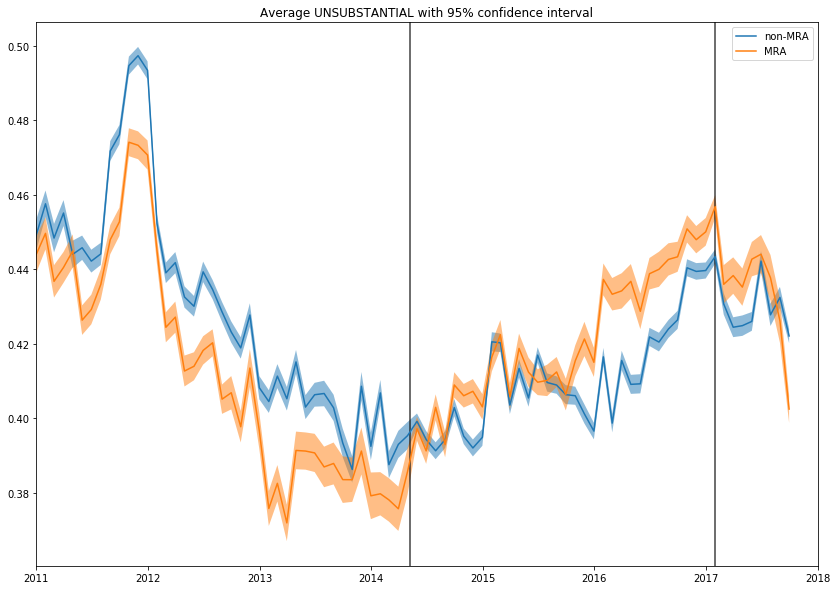

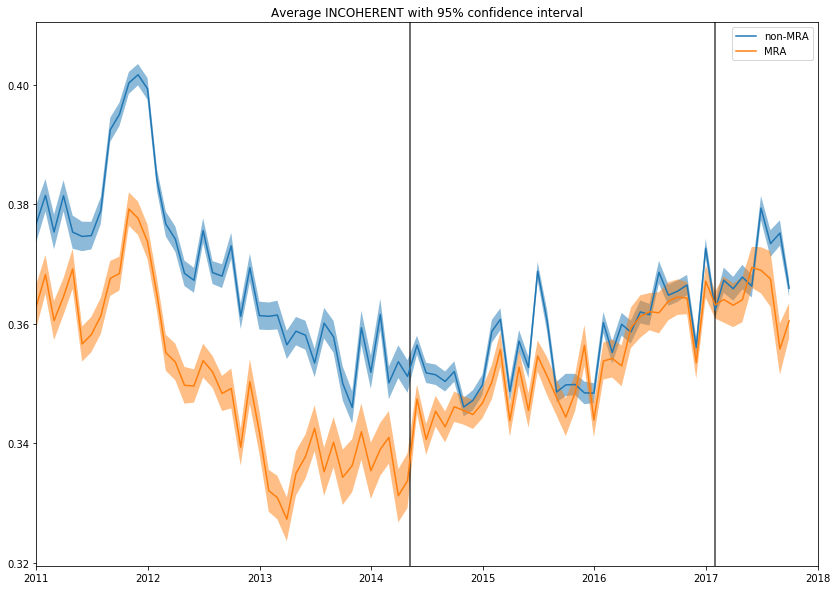

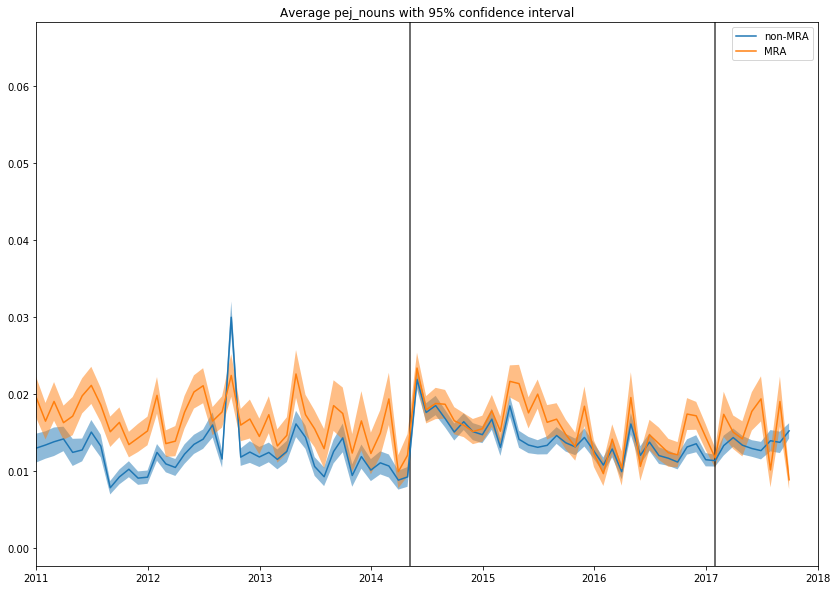

In [22]:
for c in ['politeness', 'sentiment', 'TOXICITY',
       'ATTACK_ON_COMMENTER', 'INFLAMMATORY', 'LIKELY_TO_REJECT',
       'OBSCENE', 'SEVERE_TOXICITY', 'ATTACK_ON_AUTHOR', 'SPAM',
       'UNSUBSTANTIAL', 'INCOHERENT', 'pej_nouns']:
    plot_users(mra_grouped, column=c, 
           cohorts=['non-MRA', 'MRA'], 
           agg='mean', years =[2011,2018], 
           events=events)